In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# mnist 파일 불러오기
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
# x, y 값 나누기
# mnist 데이터 중 필요한 data와 target만 가져온다.
x, y = mnist['data'], mnist['target']
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# 전체 데이터 중 하나의 이미지만 가져와 그래프로 확인해본다.
some_digit = x[0]
some_digit_image = some_digit.reshape(28, 28)

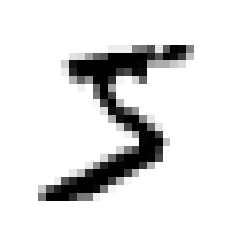

In [5]:
# 그래프로 표시했을 때 5를 나타내는 것을 볼 수 있다.
# cmap을 binary로 표시하면 흰, 검 두개로 나타난다.
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
# 실제 레이블 값도 5이다.
y[0]

5

In [8]:
# 문자열로 되어있는 y 값을 정수값으로 바꾸어준다.
y = y.astype(int)

In [10]:
# mnist 데이터 셋은 6만개 이전을 train, 6만개 이후를 test로 구분해놓았기 때문에 train, test set을 생성해준다.
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [11]:
# label이 5인 데이터만 한번 훈련해보도록하자.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# 모델은 SGD(stochastic gradient descent : 확률적 경사 하강법)를 사용한다.
# 모든 학습용 데이터를 다 사용하여 그레디언트를 구하는 것이 아니라 미니배치(minibatch)라고 부르는 일부의 데이터만 사용하여 
# 그레디언트 추정치를 구한다. 따라서 한번의 계산량이 많거나 학습데이터가 많은 딥러닝(deep learning)에 사용된다. 
# 퍼셉트론은 오분류된(mis-classified) 데이터만 이용하는 SGD의 일종이다.
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
# 제대로 예측한 것을 알 수 있다.
sgd_clf.predict([some_digit])

array([ True])

In [14]:
# cross_val_score를 사용하지 않고 직접 구현한 코드이다.
# 0.96215, 0.94995, 0.9673의 성능을 나타낸다.
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96215
0.94995
0.9673


In [15]:
# cross_val_score를 사용하여 학습시켰다.
# 0.95035, 0.96035, 0.9604의 성능을 나타낸다.
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
# label 중 5가 아닌 숫자들의 모델 생성
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [18]:
# 5에 대한 모델 생성
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [19]:
# 약 5만 개의 데이터 중 687개를 5라고 판별했고 5000개의 데이터중 1891개를 잘못 예측했다.
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
# 정밀도는 약 83%로 나타났다.
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
# 재현율은 약 65%로 나타났다. (5가 아닌 숫자들 보다 5인 숫자를 잘 못맞춘다.)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
# f1 score는 약 73%로 나타났다.
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
# 모델.decision_function으로 각 샘플의 점수를 확인할 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# 임계값을 0으로 잡고 0보다 큰 점수들을 True, 작은 점수들을 False로 결정할 수 있다.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True, False, False, ...,  True, False, False])

In [26]:
# 반대로 임계점을 높여 8000 보다 큰 점수들을 True, 작은 점수들을 False라고도 결정할 수 있다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ...,  True, False, False])

In [24]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

In [27]:
# 적절한 임곗값을 찾기 위해 precision_recall_predict 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("임곗값", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

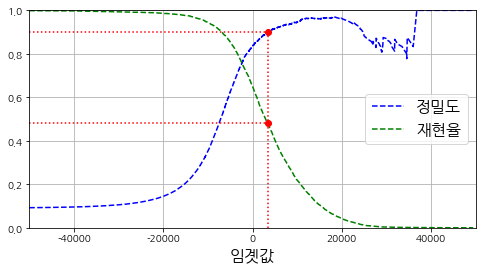

In [29]:
# 정밀도가 높으면 재현율이 낮고 정밀도가 낮으면 재현율이 높기 때문에 적절한 임곗값을 찾는 것이 중요하다.
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                              
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                         
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                 
plt.show()

In [30]:
(y_train_pred == (y_scores > 0)).all()

True

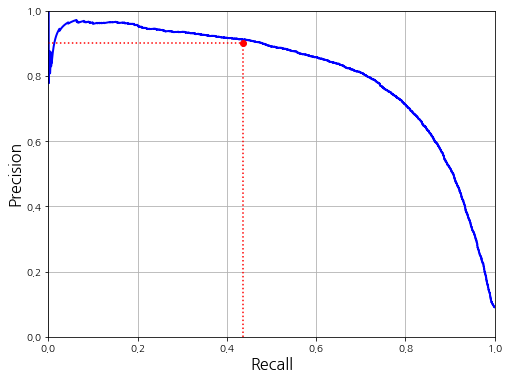

In [34]:
# 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.
# 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], 'r:')
plt.plot([0.0, 0.4368], [0.9, 0.9], 'r:')
plt.plot([0.4368], [0.9], 'ro')
plt.show()

In [35]:
# 위의 그림에서 임계값이 약 8000 정도라는 것을 알 수 있다.
# 좀더 정확하게 최소 90%의 정밀도가 되는 가장 낮은 임계값을 찾을 수 있다.
# argmax는 최댓값의 첫번째 인덱스를 반환한다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
# 정밀도를 90%까지 끌어올렸지만 재현률이 너무 낮아 좋은 모델이라 보기 어렵다.
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [39]:
# 이번엔 ROC 그래프를 보고 모델을 해석해보자.
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율')
    plt.ylabel('진짜 양성 비율(재현율)')
    plt.grid()

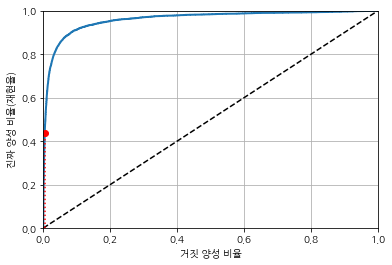

In [41]:
# 재현율이 높을 수록 분류기가 만드는 거짓 양성이 늘어난다.
# 면적이 1에 가까울 수록 좋은 모델이다.
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [43]:
# RandomForest 모델에서 확인해보자.
rf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf, x_train, y_train_5, cv=3, method='predict_proba')

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

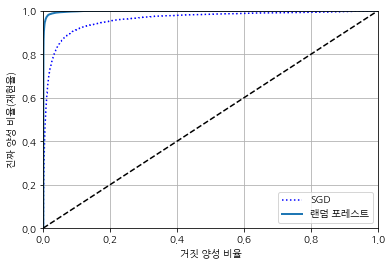

In [45]:
# 이전의 SGD 모델보다 훨씬 좋아진 것을 확인할 수 있다.
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [46]:
# 거의 100%에 가까운 성능을 낸다.
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
# 이번엔 다중 분류기인 SVC를 통해 학습해보자.
svm = SVC()
svm.fit(x_train, y_train)
svm.predict([some_digit])

array([5])

In [48]:
some_digit_scores = svm.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
svm.classes_[5]

5

In [52]:
# SGD Classification 으로도 다중 분류를 할 수 있다.
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3])

In [53]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [54]:
# 스케일링을 진행하면 조금 더 좋은 성능을 낼 수 있다.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [55]:
# 분류한 결과를 confusion matrix로 확인해보자.
# 9와 다른 숫자들의 구분이 조금 힘든 것으로 보인다.
# 또한 3, 5사이에서도 구분이 안되는 몇가지 케이스가 보인다.
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

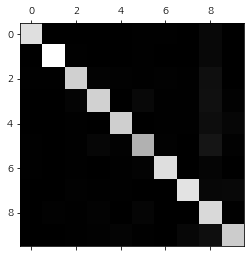

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

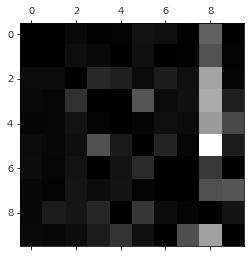

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

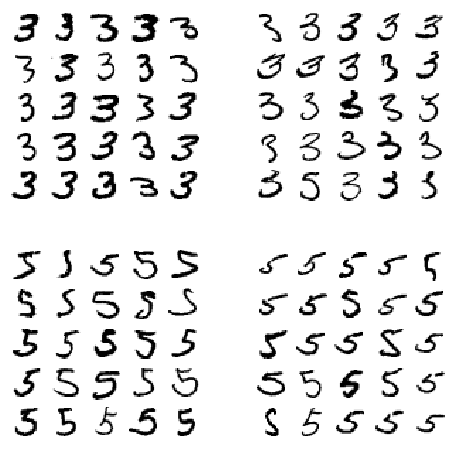

In [61]:
# 사람이 보기에도 구분이 힘든 숫자들이 있다.
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [62]:
# 두개의 타깃 레이블이 담긴 다중 레이블 분류도 만들 수 있다.
# 7보다 큰가?, 홀수인가?? 두개를 예측하는 모델도 생성해보자.
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

In [ ]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn.clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)